In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
import time
import importlib
import sys
sys.path.append('..')

import GaussianMixture4Modes as algo
import utils as u
importlib.reload(algo)
importlib.reload(u)

<module 'utils' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/GaussianMixture4Modes/../utils.py'>

Multimodial Gaussian mixture target from Example 2 of [Lu et al. 2019](https://arxiv.org/abs/1905.09863).

In [2]:
d = 2
weights = np.ones(4)/4
ms = np.array([[0, 8], [0, 2], [-3, 5], [3, 5]])
Sigmas = np.array([[[1.2, 0], [0, 0.01]], [[1.2, 0], [0, 0.01]], [[0.01, 0], [0, 2]],[[0.01, 0], [0, 2]]])

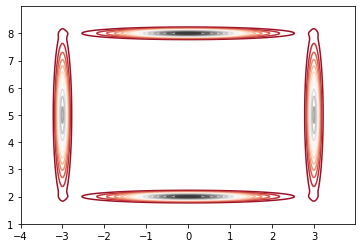

In [3]:
xx = np.arange(-4, 4, 0.01)
yy = np.arange(1, 9, 0.01)
x, y = np.mgrid[-4:4:.01, 1:9:.01]
data = np.dstack((x, y))
z = 0
zx = 0
zy = 0
for j in range(weights.size):
    z += weights[j]*multivariate_normal.pdf(data, ms[j,:], Sigmas[j,:,:])
    zx += weights[j]*norm.pdf(xx, ms[j, 0], np.sqrt(Sigmas[j, 0, 0]))
    zy += weights[j]*norm.pdf(yy, ms[j, 1], np.sqrt(Sigmas[j, 1, 1]))
plt.contour(x, y, z, 15, cmap='RdGy')

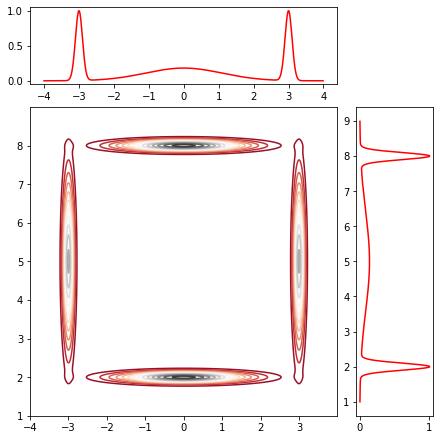

In [4]:
fig, axs = plt.subplot_mosaic([['histx', '.'],
                               ['scatter', 'histy']],
                              figsize=(6, 6),
                              width_ratios=(4, 1), height_ratios=(1, 4),
                              layout='constrained')
axs['scatter'].contour(x, y, z, 15, cmap='RdGy')
axs['histx'].plot(xx, zx, c = 'red')
axs['histy'].plot(zy, yy, c = 'red')

In [5]:
Niter = 500
gamma = 0.01
N = 500
h = gamma
X0 = np.random.multivariate_normal(ms[0,:], Sigmas[0,:,:], size = N)

In [7]:
start = time.time()
bdl = algo.BDL_kernelisedPDE(gamma, Niter, ms, Sigmas, weights, N, h, X0)
end = time.time()
end-start

4.525201082229614

In [8]:
start = time.time()
bdl_v2 = algo.BDL_kernelisedKL(gamma, Niter, ms, Sigmas, weights, N, h, X0)
end = time.time()
end-start

4.603444814682007

In [9]:
start = time.time()
wfr_x, wfr_w = algo.SMC_WFR(gamma, Niter, ms, Sigmas, weights, X0)
end = time.time()
end-start

4.584706783294678

Text(0.5, 1.0, 'WFR')

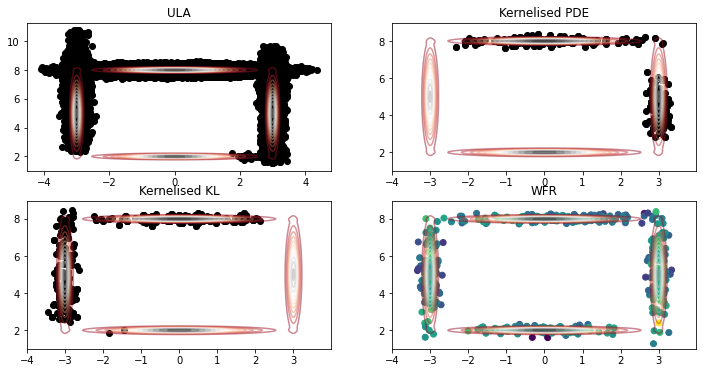

In [10]:
plt.figure(figsize = (12,6))
plt.subplot(2, 2, 1)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(ula_chain[:N, 0], ula_chain[:N, 1], color = 'black');
plt.title('ULA')
plt.subplot(2, 2, 2)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(bdl[-1, 0, :], bdl[-1, 1, :], color = 'black');
plt.title('Kernelised PDE')
plt.subplot(2, 2, 3)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(bdl_v2[-1, 0, :], bdl_v2[-1, 1, :], color = 'black');
plt.title('Kernelised KL')
plt.subplot(2, 2, 4)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(wfr_x[-1, 0, :], wfr_x[-1, 1, :], c = wfr_w[-1, :]);
plt.title('WFR')
# plt.colorbar();
# plt.subplots_adjust(left=-1,
#                     bottom=-1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.2,
#                     hspace=0.2)
# plt.show()
# plt.savefig("GaussianMixture4Modes.pdf")

In [11]:
true_mean = np.mean(ms, axis = 0)
true_variance = np.zeros((d, d))
for i in range(4):
    true_variance += Sigmas[i, :, :] + np.matmul((ms[i, :] - true_mean)[:, None], (ms[i, :] - true_mean)[:, None].T)
true_variance = true_variance/4

In [12]:
i = 0
Sigmas[i, :, :]

array([[1.2 , 0.  ],
       [0.  , 0.01]])

In [13]:
mean_bdl = np.mean((np.mean(bdl, axis = 2) - true_mean)**2, axis = 1)
mean_bdl_v2 = np.mean((np.mean(bdl_v2, axis = 2) - true_mean)**2, axis = 1)
mean_wfr = np.zeros(Niter)
cov_bdl = np.zeros(Niter)
cov_bdl_v2 = np.zeros(Niter)
cov_wfr = np.zeros(Niter)
for i in range(Niter):
    cov_bdl[i] = np.mean((np.cov(bdl[i, :, :]) - true_variance)**2)
    cov_bdl_v2[i] = np.mean((np.cov(bdl_v2[i, :, :]) - true_variance)**2)
    current_mean = np.sum(wfr_x[i, :, :]*wfr_w[i, :], axis = 1)
    mean_wfr[i] = np.mean((current_mean - true_mean)**2)
    cov_mat = np.array([[np.sum(wfr_x[i, 0, :]*wfr_w[i, :]*wfr_x[i, 0, :]) - current_mean[0]*current_mean[0], np.sum(wfr_x[i, 0, :]*wfr_w[i, :]*wfr_x[i, 1, :]) - current_mean[0]*current_mean[1]], [np.sum(wfr_x[i, 0, :]*wfr_w[i, :]*wfr_x[i, 1, :]) - current_mean[0]*current_mean[1], np.sum(wfr_x[i, 1, :]*wfr_w[i, :]*wfr_x[i, 1, :]) - current_mean[1]*current_mean[1]]])
    cov_wfr[i] = np.mean((cov_mat - true_variance)**2)

In [14]:
component = np.random.randint(4, size = N*100)
true_sample = np.zeros((N, 2))
for n in range(N):
      true_sample[n, :] = np.random.multivariate_normal(ms[component[n], :], Sigmas[component[n], :, :], size = 1)

In [15]:
mmd_bdl = np.zeros(Niter)
mmd_bdl_v2 = np.zeros(Niter)
mmd_wfr = np.zeros(Niter)
w1_bdl = np.zeros((Niter, d))
w1_bdl_v2 = np.zeros((Niter, d))
w1_wfr = np.zeros((Niter, d))
for i in range(Niter):
    mmd_bdl[i] = u.mmd_rbf(true_sample, bdl[i, :, :].T)
    mmd_bdl_v2[i] = u.mmd_rbf(true_sample, bdl_v2[i, :, :].T)
    mmd_wfr[i] = u.mmd_rbf(true_sample, wfr_x[i, :, :].T, w = wfr_w[i, :])
    for j in range(d):
        w1_bdl[i, j]  = stats.wasserstein_distance(bdl[i, j, :], true_sample[:, j])
        w1_bdl_v2[i, j] = stats.wasserstein_distance(bdl_v2[i, j, :], true_sample[:, j])
        w1_wfr[i, j]  = stats.wasserstein_distance(wfr_x[i, j, :], true_sample[:, j], u_weights = wfr_w[i, :])

Text(0.5, 1.0, 'Max W_1')

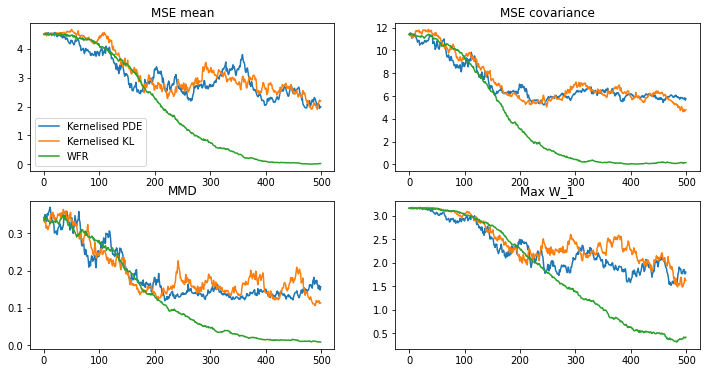

In [16]:
plt.figure(figsize = (12,6))
plt.subplot(2, 2, 1)
plt.plot(mean_bdl, label = 'Kernelised PDE')
plt.plot(mean_bdl_v2, label = 'Kernelised KL')
plt.plot(mean_wfr, label = 'WFR')
plt.title('MSE mean')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(cov_bdl)
plt.plot(cov_bdl_v2)
plt.plot(cov_wfr)
plt.title('MSE covariance')
plt.subplot(2, 2, 3)
plt.plot(mmd_bdl)
plt.plot(mmd_bdl_v2)
plt.plot(mmd_wfr)
plt.title('MMD')
plt.subplot(2, 2, 4)
plt.plot(np.max(w1_bdl, axis = 1))
plt.plot(np.max(w1_bdl_v2, axis = 1))
plt.plot(np.max(w1_wfr, axis = 1))
plt.title('Max W_1')
# plt.subplots_adjust(left=-1,
#                     bottom=-1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.2,
#                     hspace=0.2)
# plt.show()
# plt.savefig("GaussianMixture4Modes_diagnostics.pdf")

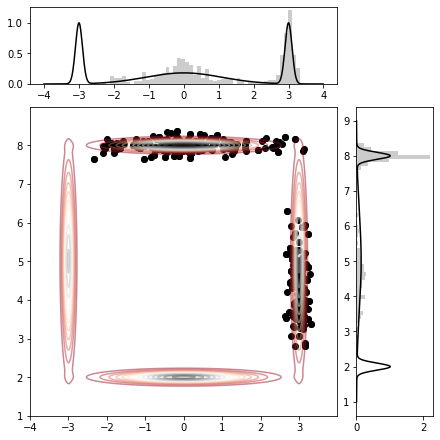

In [17]:
fig, axs = plt.subplot_mosaic([['histx', '.'],
                               ['scatter', 'histy']],
                              figsize=(6, 6),
                              width_ratios=(4, 1), height_ratios=(1, 4),
                              layout='constrained')
axs['scatter'].contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
axs['scatter'].scatter(bdl[-1, 0, :], bdl[-1, 1, :], color = 'black');
axs['histx'].plot(xx, zx, c = 'black')
axs['histx'].hist(bdl[-1, 0, :], color = 'black', alpha = 0.2, density = True, bins = 50)
axs['histy'].plot(zy, yy, c = 'black')
axs['histy'].hist(bdl[-1, 1, :], color = 'black', alpha = 0.2, density = True, bins = 50, orientation='horizontal');
# plt.savefig("GaussianMixture4Modes_bdl.pdf")

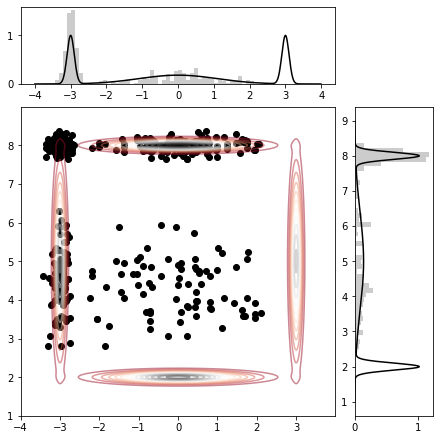

In [18]:
fig, axs = plt.subplot_mosaic([['histx', '.'],
                               ['scatter', 'histy']],
                              figsize=(6, 6),
                              width_ratios=(4, 1), height_ratios=(1, 4),
                              layout='constrained')
axs['scatter'].contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
axs['scatter'].scatter(bdl_v2[-1, 0, :], bdl[-1, 1, :], color = 'black');
axs['histx'].plot(xx, zx, c = 'black')
axs['histx'].hist(bdl_v2[-1, 0, :], color = 'black', alpha = 0.2, density = True, bins = 50)
axs['histy'].plot(zy, yy, c = 'black')
axs['histy'].hist(bdl_v2[-1, 1, :], color = 'black', alpha = 0.2, density = True, bins = 50, orientation='horizontal');
# plt.savefig("GaussianMixture4Modes_bdl_v2.pdf")

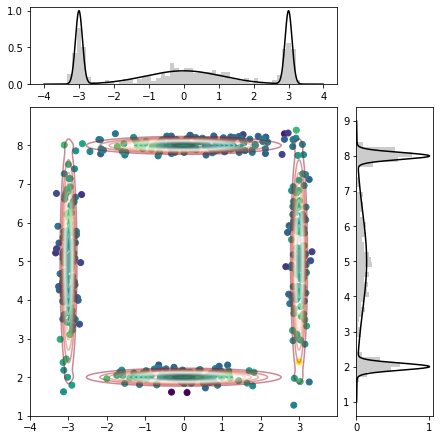

In [19]:
fig, axs = plt.subplot_mosaic([['histx', '.'],
                               ['scatter', 'histy']],
                              figsize=(6, 6),
                              width_ratios=(4, 1), height_ratios=(1, 4),
                              layout='constrained')
axs['scatter'].contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
axs['scatter'].scatter(wfr_x[-1, 0, :], wfr_x[-1, 1, :], c = wfr_w[-1, :]);
axs['histx'].plot(xx, zx, c = 'black')
axs['histx'].hist(wfr_x[-1, 0, :], weights = wfr_w[-1, :], color = 'black', alpha = 0.2, density = True, bins = 50)
axs['histy'].plot(zy, yy, c = 'black')
axs['histy'].hist(wfr_x[-1, 1, :], weights = wfr_w[-1, :], color = 'black', alpha = 0.2, density = True, bins = 50, orientation='horizontal');
# plt.savefig("GaussianMixture4Modes_smc.pdf")